### 

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color = sns.color_palette()
pd.options.display.max_columns = 70
pd.options.display.max_rows = 70

In [5]:
number_of_cols = pd.Series(range(0,57))
good_import_cols = number_of_cols.drop([22,32,34,49,55])

In [12]:
train_df1 = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])


In [13]:
prop = pd.read_csv("properties_2016.csv") #, usecols=good_import_cols)

FileNotFoundError: File b'properties_2016.csv' does not exist

Find columns where the rows have 75% or more missing values.  
We will remove these later 

In [6]:
missing_df = prop.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]

missing_df['missing_ratio'] = missing_df['missing_count'] / prop.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.75]

,column_name,missing_count,missing_ratio
2,architecturalstyletypeid,2979156,0.997970
3,basementsqft,2983589,0.999455
6,buildingclasstypeid,2972588,0.995769
9,decktypeid,2968121,0.994273
10,finishedfloor1squarefeet,2782500,0.932093
13,finishedsquarefeet13,2977545,0.997430
14,finishedsquarefeet15,2794419,0.936086
15,finishedsquarefeet50,2782500,0.932093
16,finishedsquarefeet6,2963216,0.992630
18,fireplacecnt,2672580,0.895272


Create the training set from the depedent variables we have.

In [7]:
train_df = train_df1.merge(prop, on='parcelid', how = 'left')

Impute the missing values with the mean 

In [9]:
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values, inplace=True)

Let's look at some of the counts by month 

In [10]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month
train_df.groupby(by=['transaction_month']).logerror.count()

transaction_month
1      6574
2      6401
3      8752
4      9407
5     10056
6     10968
7      9984
8     10510
9      9597
10     4991
11     1829
12     1742
Name: logerror, dtype: int64

Find which columns are not numeric -  which columns are not of type float64 

In [1]:
cols_to_drop = train_df.dtypes[train_df.dtypes != "float64"].index
train_df.dtypes[train_df.dtypes != "float64"].index

NameError: name 'train_df' is not defined

In [12]:
train_df2 = train_df.drop(['propertycountylandusecode', 'propertyzoningdesc', 'taxdelinquencyflag', 'hashottuborspa','fireplaceflag' ], axis = 1)
missing_df2 = train_df2.isnull().sum(axis=0).reset_index()
missing_df2.columns = ['count', 'val']
missing_df2[missing_df2['val'] > 0]


,count,val


In [13]:
low_cutoff = -0.2
high_cutoff = 0.2

In [14]:
high_error = train_df.logerror.values[train_df.logerror.values < low_cutoff]
low_error = train_df.logerror.values[train_df.logerror.values >  high_cutoff]
print("High Error -  Number of data points: ", len(high_error), " Pct: ",len(high_error)/len(train_df.logerror))
print("Low Error -  Number of data points: ", len(low_error), " Pct: ",len(low_error)/len(train_df.logerror))

High Error -  Number of data points:  2429  Pct:  0.026747860941956372
Low Error -  Number of data points:  3519  Pct:  0.03875081212628426


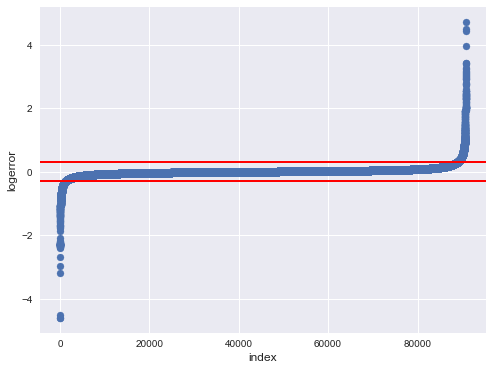

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.axhline(y = 0.3, linewidth = 2, color = 'r')
plt.axhline(y = -0.3, linewidth = 2, color = 'r')
plt.show()

In [16]:
from sklearn.preprocessing import Binarizer

In [17]:
y_low = Binarizer(threshold=low_cutoff).fit_transform(train_df['logerror'].values.reshape(-1,1))
y_high = Binarizer(threshold=high_cutoff).fit_transform(train_df['logerror'].values.reshape(-1,1))

Remember which values are encoded as 0 

For y_low the low values (of interest) are 0  
and for y_high the high values (of interest) are 1  

In [18]:
print(len(y_low[y_low ==0]))
print(len(y_high[y_high ==0]))

2429
87292


In [19]:
#train_df2.to_csv("semi_clean_df.csv")

In [77]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO  
import pydotplus
from IPython.display import Image
pd.set_option('display.notebook_repr_html', False)


In [78]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

In [79]:
dot_data1 = StringIO()
export_graphviz(clf, out_file=dot_data1, feature_names=X.columns, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data1.getvalue())

In [80]:
graph = print_tree(regr, features=X.columns)
Image(graph[0].create_png())

Exception: "dot.exe" not found in path.

In [51]:
X = train_df.drop(['parcelid', 'transactiondate', 'hashottuborspa',
       'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag',
       'taxdelinquencyflag', 'transaction_month', 'logerror'],axis = 1)
train_y = train_df['logerror']

In [52]:
regr = DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, train_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=3, min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [53]:
graph = print_tree(regr, features=X.columns)
Image(graph.create_png())

AttributeError: 'list' object has no attribute 'create_png'

In [55]:
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=6, max_features=3)
clf.fit(X,y_low)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=3, max_leaf_nodes=6, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [58]:
graph2 = print_tree(clf, features=X.columns, class_names=["0", "1"])
Image(graph2.create_png())

AttributeError: 'list' object has no attribute 'create_png'